# Time Series Forecasting
## Using Machine Learning XGBoost algorithm to Forecast Energy Consumption

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

## Types of Time Series Data

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

reference: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467

In [4]:
df = pd.read_csv('AEP_hourly.csv')
df = df.set_index('Datetime') #Replace the index column by that one.
df.index = pd.to_datetime(df.index) #To make it more organized. Use pandas datetime as index

In [5]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


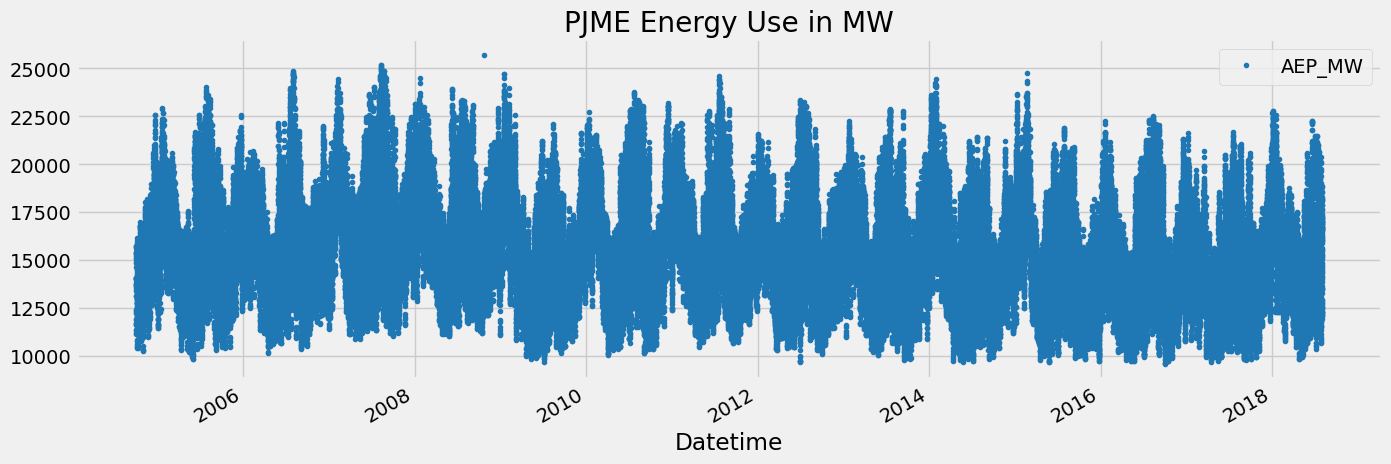

In [6]:
#Plot of all the data we have.
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# Removing Outliers

<Axes: ylabel='Frequency'>

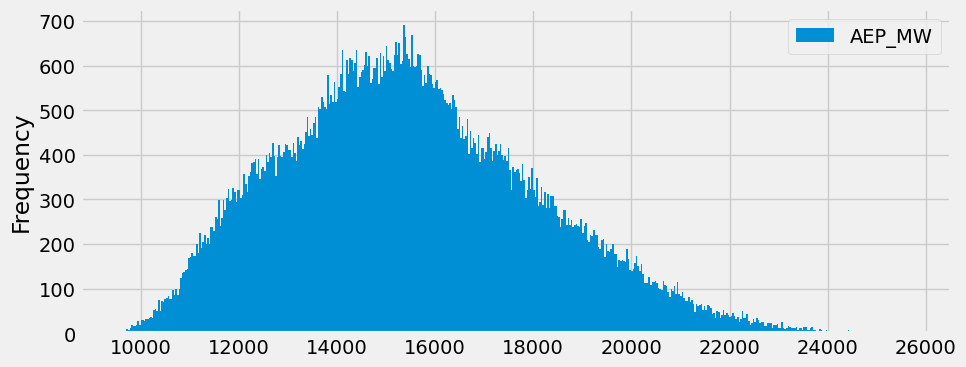

In [7]:
# Checking general behaivour
df.plot(kind='hist',bins=500, figsize=(10,4))

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

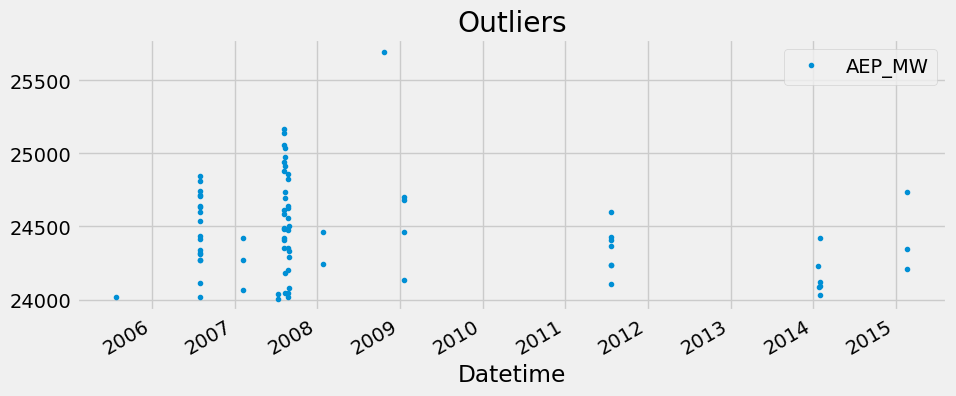

In [8]:
# Comparing possible outliers in 'PJME Energy Use in MW'
df.query('AEP_MW > 24_000').plot(figsize=(10,4), style='.', title='Outliers')

In [9]:
# Removing outliers
df = df.query(' AEP_MW < 25_500').copy()

# 1) Manually Spliting Test/Train Data

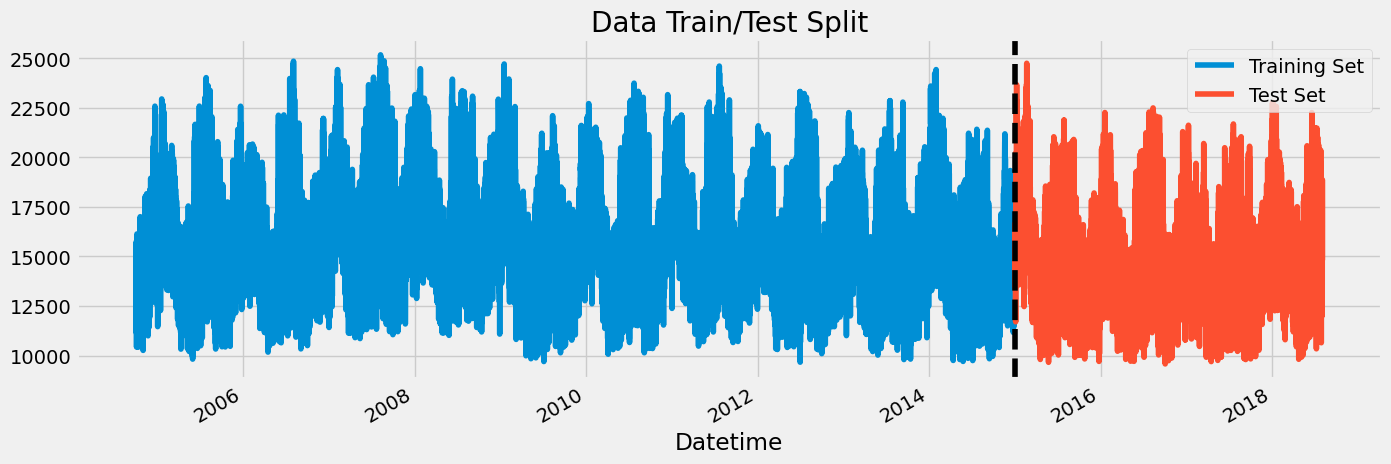

In [10]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

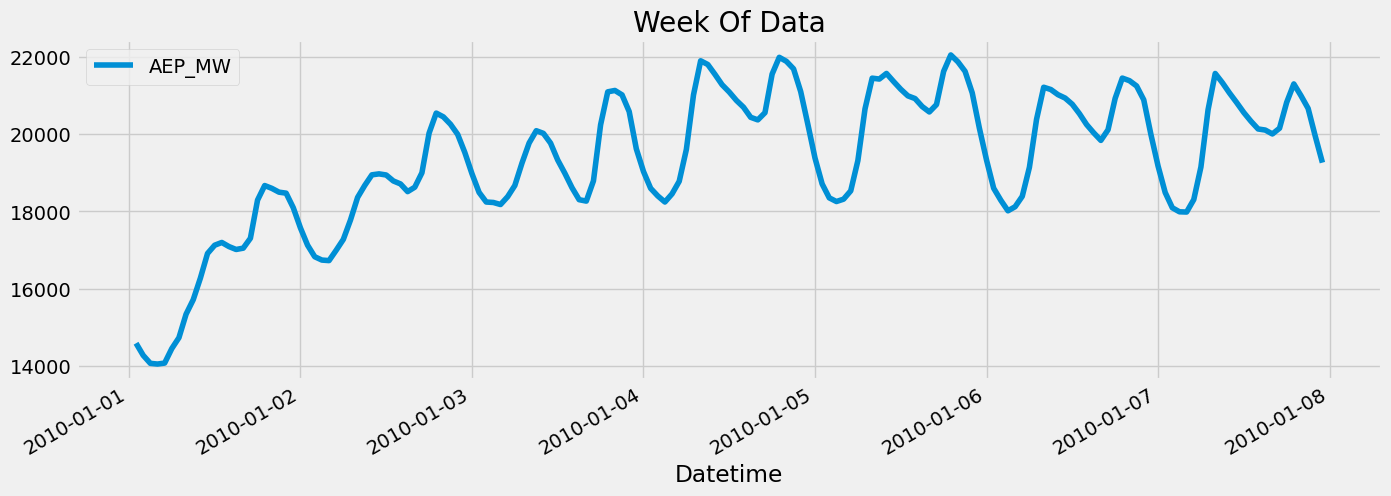

In [11]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

## Feature Creation

In [12]:
#We create a function that grabs the features we decide and return them in a data set
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)



In [13]:
#New data set organized as we want it for better use.
df.head(2)

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366,31,53
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366,31,53


## Visualize Our Feature / Target Relationship

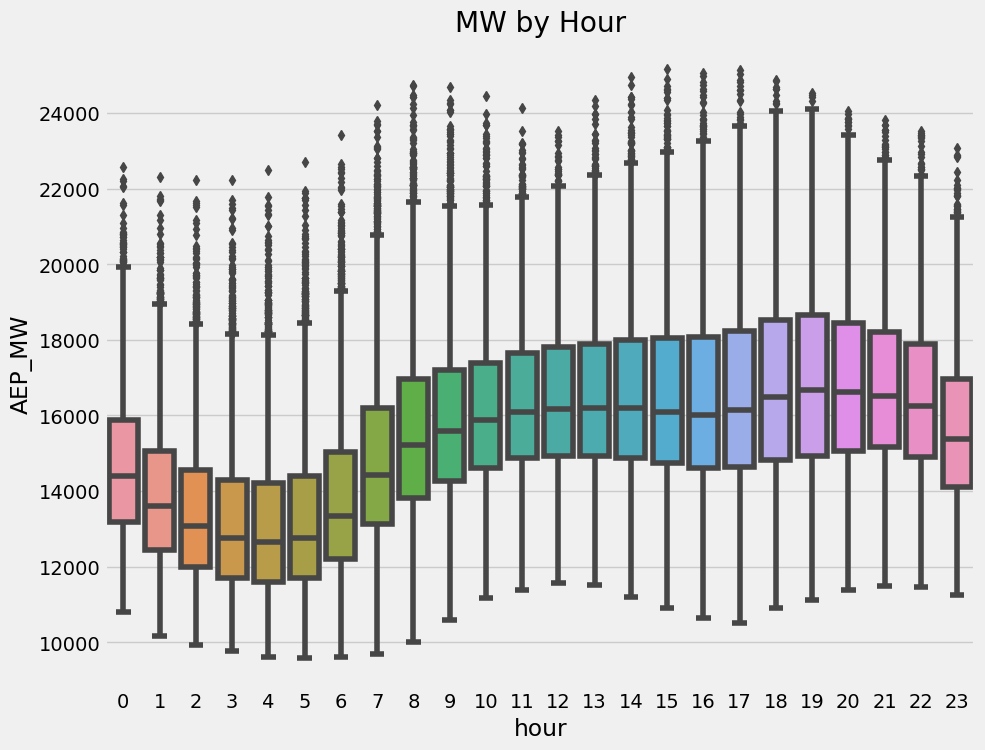

In [14]:
#Check the disttribution as a gross estimate
# per hour in the whole data set using seaborn.
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

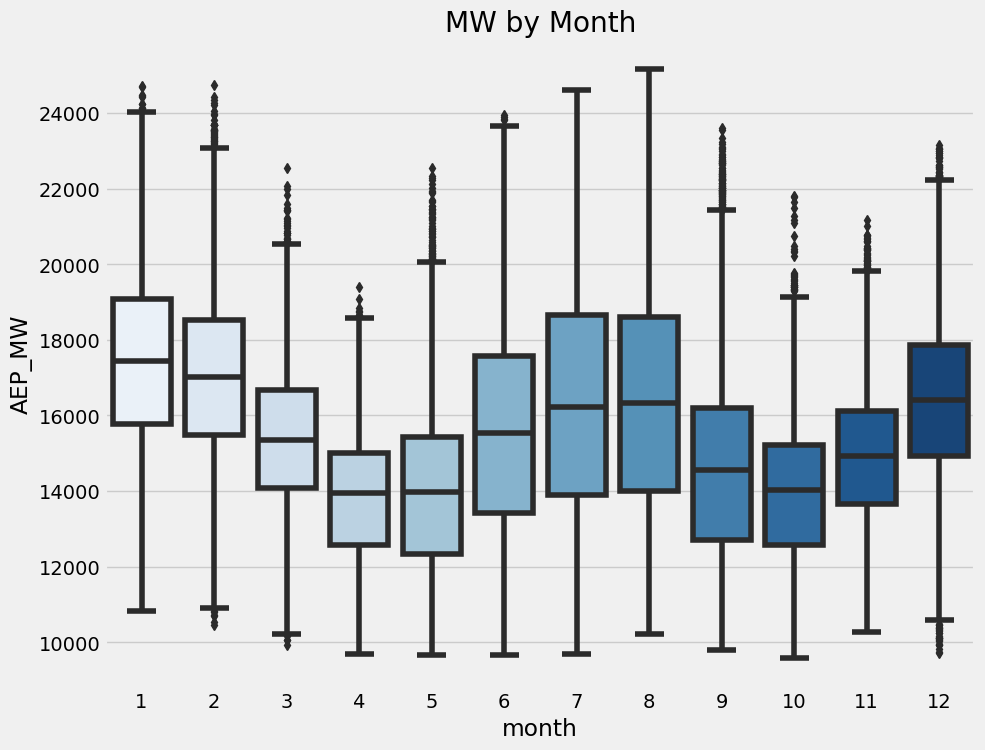

In [15]:
#Checking the seasons. In winter and summer it tends to peak
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='AEP_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

## Create Our Model

In [16]:
train = create_features(train)
test = create_features(test)

#Selecting the features we believe will work for the model.
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
#Selecting what do we whant to predict.
TARGET = 'AEP_MW'

#Train data we are going to use for the model.
X_train = train[FEATURES]
Y_train = train[TARGET]

#Test data we are going to use for the model.
X_test = test[FEATURES]
Y_test = test[TARGET]

In [17]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50, #Stops when predictions stops improving.
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01) #Low learning rate to prevent rapid overfitting.
reg.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        verbose=100)

[0]	validation_0-rmse:15793.11997	validation_1-rmse:14861.30090


/Users/carlosgutierrez/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:01:32] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:6033.82481	validation_1-rmse:5144.91578
[200]	validation_0-rmse:2703.39623	validation_1-rmse:2161.59402
[300]	validation_0-rmse:1754.70019	validation_1-rmse:1666.71795
[391]	validation_0-rmse:1528.48792	validation_1-rmse:1657.36712


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Feature Importance

In [18]:
#This shows the importance of each feature in our model. AKA: how much each feature
# was used by the trees in the model.
#It is important to notice that it follows the order given by the "FEATURES" list.
reg.feature_importances_

array([0.15631549, 0.30639204, 0.2505334 , 0.07521504, 0.14774542,
       0.06379859], dtype=float32)

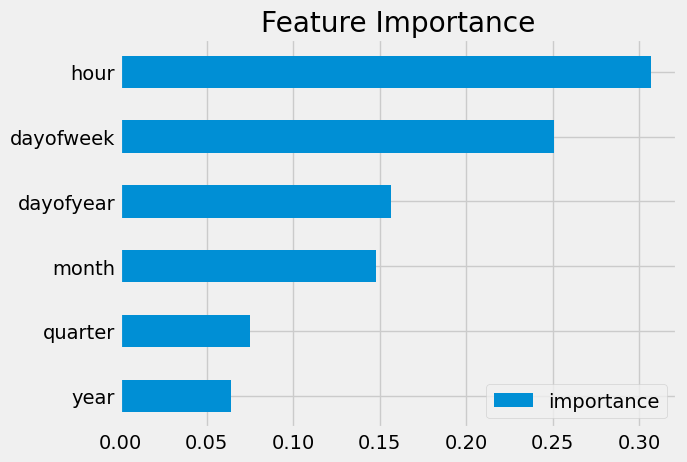

In [19]:
fi = pd.DataFrame(data=reg.feature_importances_, #Importance values
             index=reg.feature_names_in_, #Importance values's names
             columns=['importance']) #For naming the column in the DataFrame. 
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

For highly correlated features, this is not that much of reliable information for how important each feature is individually. In this example at least.

## Forecast on Test

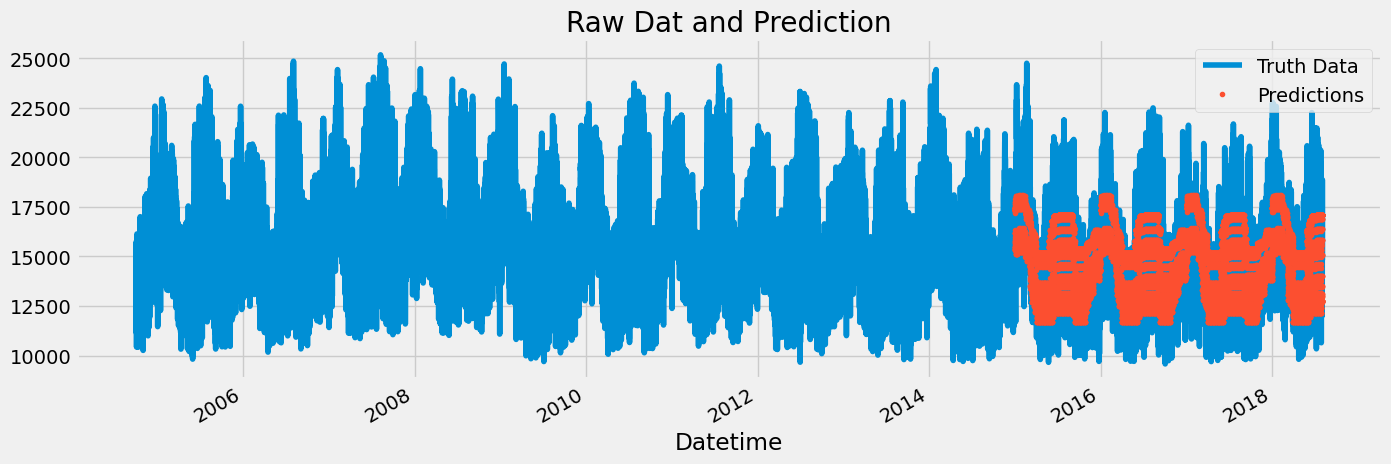

In [20]:
test['prediction'] = reg.predict(X_test) #Create a new column for the predicted data
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True) #Merge to the df

#Plot the original data as well as the prediction. 
ax = df[['AEP_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

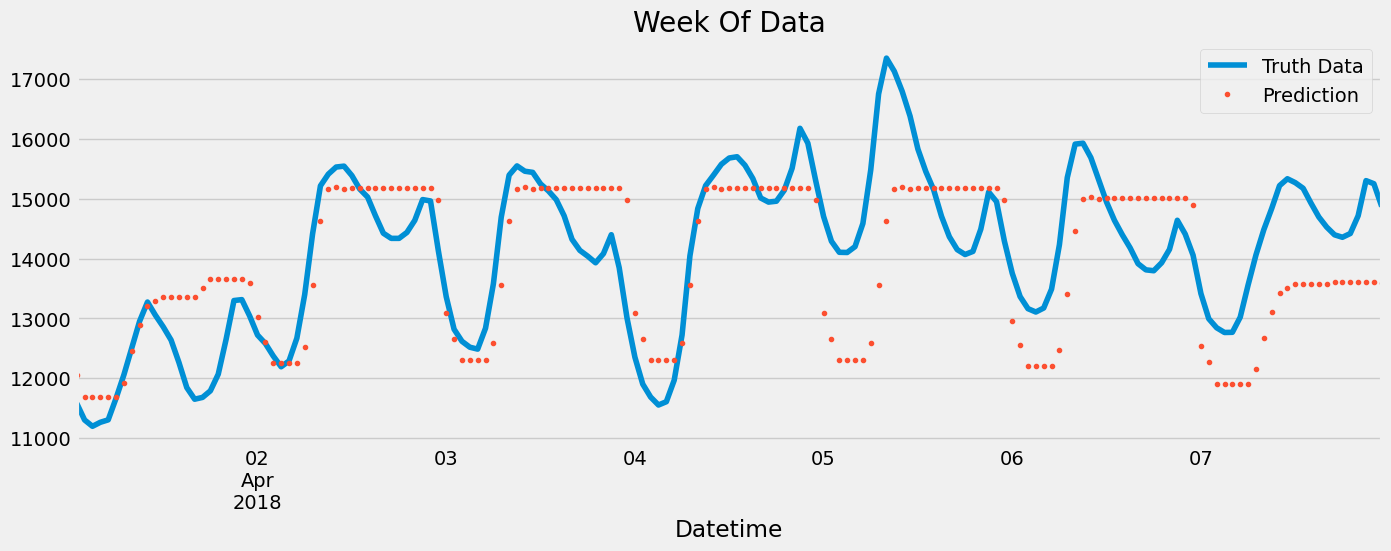

In [21]:
#Ploting a smaller section of the data to see more clearly the predictions.
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

**We see the prediction is not that great. Although it can be upgraded, it shows a similar behavior of the original data. It mostly goes up when it should, and down as well.**

## Score (RMSE)

In [23]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1648.91


## Calculate Error
- Look at the worst and best predicted days

In [24]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2015-02-19    5648.796794
2015-02-20    5414.053670
2018-01-06    4838.635213
2015-01-08    4730.741414
2015-12-25    4445.658773
2015-02-16    4429.345500
2015-12-24    4164.703939
2015-02-15    4100.945557
2018-01-05    4071.399333
2018-01-07    4063.868083
Name: error, dtype: float64

# 2) Time Series Cross Validation
- This time, we are going use a time series split instead of manually splitting the data

In [25]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

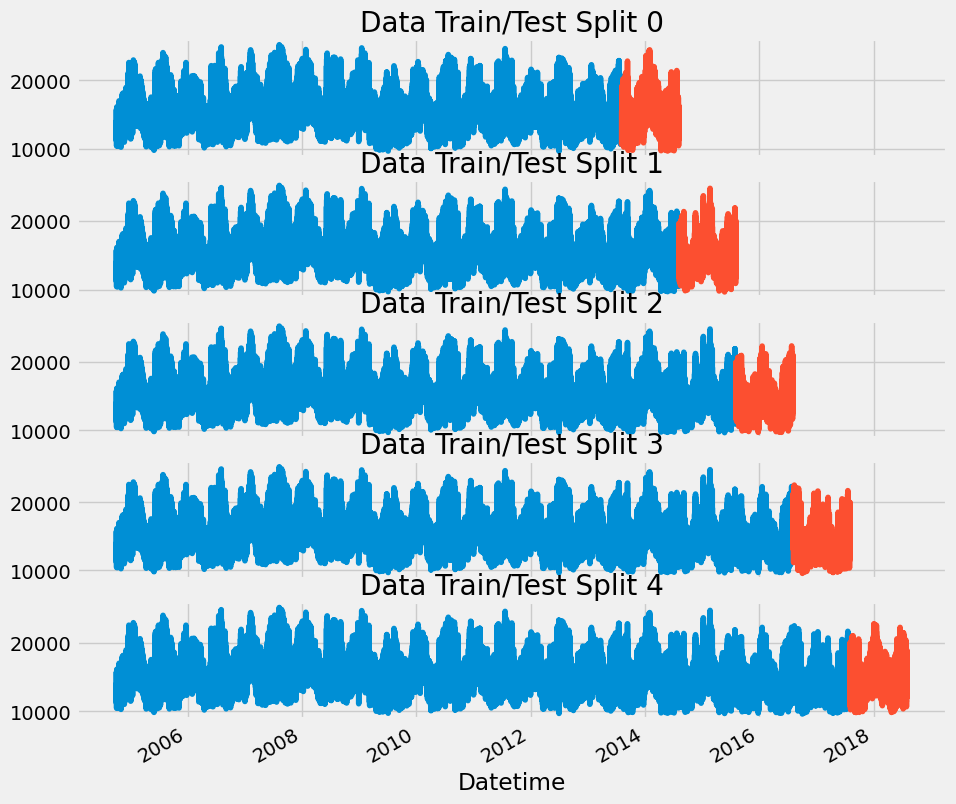

In [89]:
fig, axs = plt.subplots(5, 1, figsize=(10,10), sharex=True)

fold = 0
for train_indx, test_indx in tss.split(df):
    train = df.iloc[train_indx]
    test = df.iloc[test_indx]
    train['AEP_MW'].plot(ax=axs[fold], title=f'Data Train/Test Split {fold}', label='Train')
    test['AEP_MW'].plot(ax=axs[fold], label='Test')

    fold += 1

## Forecasting Horizon: Lag Feature

In [27]:
#We create a function that grabs the features we decide and return them in a data set
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [28]:
#New data set organized as we want it for better use.
df.head(2)

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275,1,40,NaN
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275,1,40,NaN


In [29]:
def add_lags(df):
    target_map = df['AEP_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) #364/7 = 52.0
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [30]:
df = add_lags(df)

In [31]:
df.tail(3)

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction,lag1,lag2,lag3
Datetime,,,,,,,,,,,,,
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,2,31,17112.402344,17544.0,19246.0,15783.0
2018-08-02 23:00:00,15964.0,23,3,3,8,2018,214,2,31,16909.298828,16262.0,17943.0,14808.0
2018-08-03 00:00:00,14809.0,0,4,3,8,2018,215,3,31,13482.082031,15045.0,16491.0,13669.0


## Create Our Model Using Cross Validation

In [32]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []

for train_indx, val_indx in tss.split(df):
    train = df.iloc[train_indx]
    test = df.iloc[val_indx]

    train = create_features(train)
    test = create_features(test)

    #Selecting the features we believe will work for the model.
    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
    #Selecting what do we whant to predict.
    TARGET = 'AEP_MW'

    #Train data we are going to use for the model.
    X_train = train[FEATURES]
    Y_train = train[TARGET]

    #Test data we are going to use for the model.
    X_test = test[FEATURES]
    Y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50, #Stops when predictions stops improving.
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01) #Low learning rate to prevent rapid overfitting.
    reg.fit(X_train, Y_train,
            eval_set=[(X_train, Y_train), (X_test, Y_test)],
            verbose=100)
    
    Y_pred = reg.predict(X_test)
    preds.append(Y_pred)
    score = np.sqrt( mean_squared_error(Y_test, Y_pred) )
    scores.append(score)

[0]	validation_0-rmse:15898.36708	validation_1-rmse:15260.23878


/Users/carlosgutierrez/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:03:50] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:6067.00882	validation_1-rmse:5470.79603
[200]	validation_0-rmse:2700.40703	validation_1-rmse:2316.45699
[300]	validation_0-rmse:1732.77152	validation_1-rmse:1686.73722
[400]	validation_0-rmse:1493.56834	validation_1-rmse:1638.89227
[500]	validation_0-rmse:1414.93758	validation_1-rmse:1632.14397
[600]	validation_0-rmse:1372.42947	validation_1-rmse:1620.68575
[700]	validation_0-rmse:1343.33204	validation_1-rmse:1609.28343
[800]	validation_0-rmse:1320.57051	validation_1-rmse:1583.08177
[900]	validation_0-rmse:1300.68900	validation_1-rmse:1569.72929
[999]	validation_0-rmse:1284.12742	validation_1-rmse:1563.74294
[0]	validation_0-rmse:15835.35647	validation_1-rmse:15217.54258


/Users/carlosgutierrez/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:03:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:6049.04302	validation_1-rmse:5454.23050
[200]	validation_0-rmse:2708.01450	validation_1-rmse:2306.87189
[300]	validation_0-rmse:1756.74478	validation_1-rmse:1622.85803
[400]	validation_0-rmse:1521.25644	validation_1-rmse:1517.09392
[500]	validation_0-rmse:1437.13579	validation_1-rmse:1490.06449
[600]	validation_0-rmse:1394.03538	validation_1-rmse:1471.23671
[700]	validation_0-rmse:1365.12177	validation_1-rmse:1456.23800
[800]	validation_0-rmse:1341.76862	validation_1-rmse:1439.16383
[900]	validation_0-rmse:1324.00309	validation_1-rmse:1429.78720
[999]	validation_0-rmse:1309.76326	validation_1-rmse:1425.62386
[0]	validation_0-rmse:15779.28416	validation_1-rmse:14544.90931


/Users/carlosgutierrez/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:03:55] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:6029.70225	validation_1-rmse:4859.14614
[200]	validation_0-rmse:2705.32937	validation_1-rmse:1920.76996
[300]	validation_0-rmse:1760.28119	validation_1-rmse:1556.22815
[349]	validation_0-rmse:1607.96822	validation_1-rmse:1578.97158
[0]	validation_0-rmse:15679.58160	validation_1-rmse:14623.45042


/Users/carlosgutierrez/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:03:57] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:5999.77478	validation_1-rmse:5098.84519
[200]	validation_0-rmse:2707.45374	validation_1-rmse:2233.92049
[300]	validation_0-rmse:1770.72308	validation_1-rmse:1728.79824
[400]	validation_0-rmse:1531.95777	validation_1-rmse:1660.34230
[500]	validation_0-rmse:1453.16123	validation_1-rmse:1635.37243
[600]	validation_0-rmse:1406.06178	validation_1-rmse:1606.62860
[700]	validation_0-rmse:1375.29964	validation_1-rmse:1586.62901
[800]	validation_0-rmse:1353.36127	validation_1-rmse:1572.33294
[900]	validation_0-rmse:1336.70757	validation_1-rmse:1559.18124
[999]	validation_0-rmse:1323.75722	validation_1-rmse:1543.36668
[0]	validation_0-rmse:15600.97689	validation_1-rmse:15005.52596


/Users/carlosgutierrez/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:04:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:5976.21914	validation_1-rmse:5574.23125
[200]	validation_0-rmse:2705.98989	validation_1-rmse:2604.70873
[300]	validation_0-rmse:1777.61416	validation_1-rmse:1875.64351
[400]	validation_0-rmse:1538.02009	validation_1-rmse:1722.34141
[500]	validation_0-rmse:1457.46518	validation_1-rmse:1699.87808
[600]	validation_0-rmse:1416.03115	validation_1-rmse:1689.70290
[653]	validation_0-rmse:1397.13606	validation_1-rmse:1691.27399


In [33]:
scores

[1563.6469906524405,
 1424.2394338427612,
 1555.8687497109058,
 1543.3666818055224,
 1688.6319723110116]

In [34]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold Scores: {scores}')

Score across folds 1555.1508
Fold Scores: [1563.6469906524405, 1424.2394338427612, 1555.8687497109058, 1543.3666818055224, 1688.6319723110116]


## Predicting the Future

In [35]:
# Retrain on all data

df = create_features(df)

#Selecting the features we believe will work for the model.
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
#Selecting what do we whant to predict.
TARGET = 'AEP_MW'

X_all = df[FEATURES]
Y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learn_rate=0.01)

reg.fit(X_all, Y_all,
        eval_set=[(X_all, Y_all)],
        verbose=100)

[0]	validation_0-rmse:11090.71572


/Users/carlosgutierrez/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/carlosgutierrez/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [21:04:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "learn_rate" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1191.33261
[200]	validation_0-rmse:1099.07520
[300]	validation_0-rmse:1046.46854
[400]	validation_0-rmse:1010.62227
[499]	validation_0-rmse:985.56621


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learn_rate=0.01, learning_rate=None,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, ...)

In [37]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [72]:
# Create future dataframe
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [73]:
future_w_features = df_and_future.query('isFuture').copy()

In [74]:
future_w_features['prediction'] = reg.predict(future_w_features[FEATURES])

<Axes: title={'center': 'Future Prediction'}>

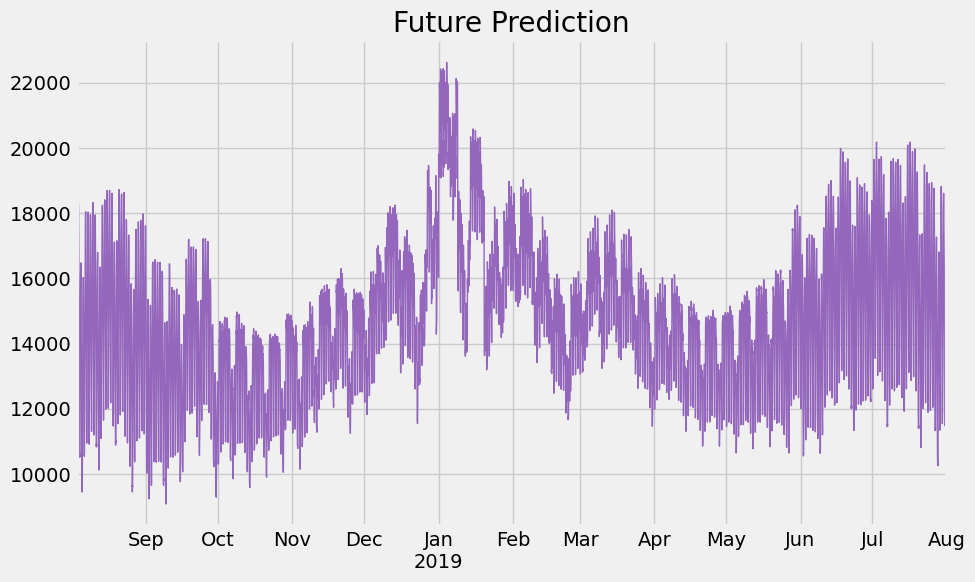

In [82]:
future_w_features['prediction'].plot(title='Future Prediction', color=color_pal[4], 
                                     figsize=(10,6), ms=1, lw=1)

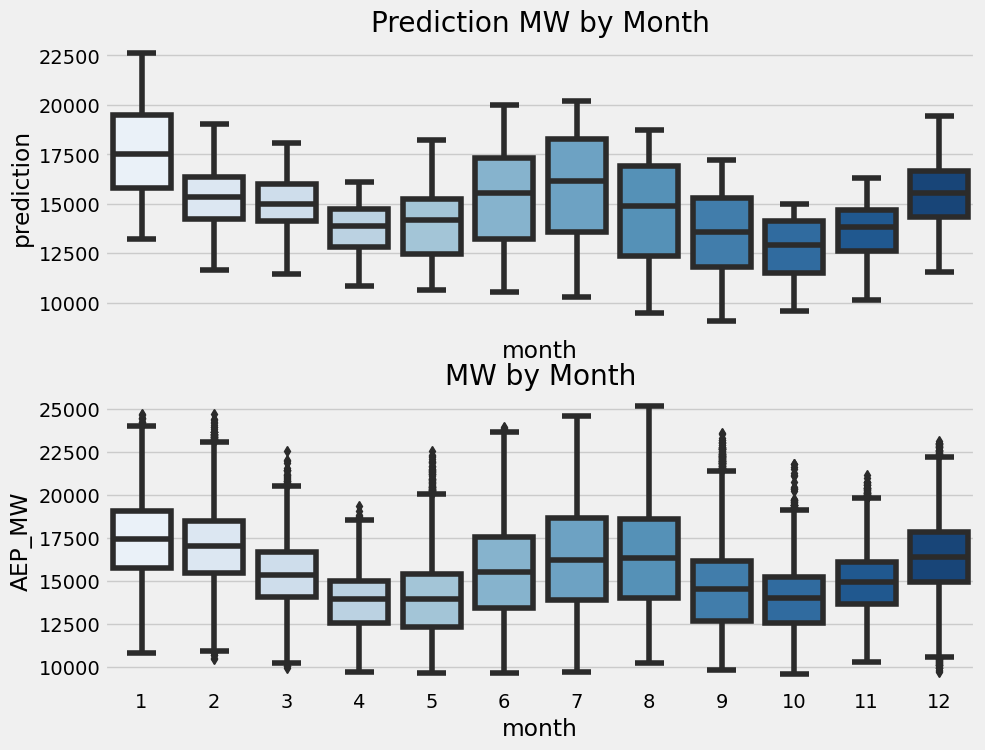

In [123]:
# Comparing prediction with general behaviour of the data set

fig, ax = plt.subplots(2,1,figsize=(10, 8), sharex=True)
sns.boxplot(ax=ax[0], data=future_w_features, x='month', y='prediction', palette='Blues')
ax[0].set_title('Prediction MW by Month')

sns.boxplot(ax=ax[1], data=df, x='month', y='AEP_MW', palette='Blues')
ax[1].set_title('MW by Month')
plt.show()

# Saving Model for Re-use

In [90]:
# Save model
reg.save_model('model_V01.json')

In [91]:
!ls -lh

total 11304
-rw-r--r--@ 1 carlosgutierrez  staff   3.2M Oct  4  2019 AEP_hourly.csv
-rw-r--r--@ 1 carlosgutierrez  staff   610K Oct  1 15:53 AEP_hourly.csv.zip
-rw-r--r--  1 carlosgutierrez  staff   556K Dec 10 22:37 model_V01.json
-rw-r--r--@ 1 carlosgutierrez  staff   1.1M Dec 10 22:32 timeSerieSforecasting.ipynb


In [93]:
# Load a model
reg_new = xgb.XGBRegressor()
reg_new.load_model('model_V01.json')

<Axes: title={'center': 'Original Model Pred'}>

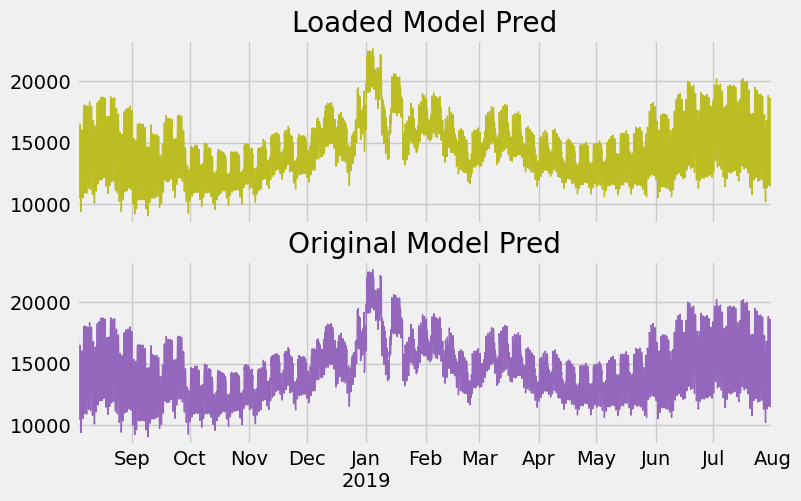

In [104]:
# Creating new farme-index
new_future_w_features = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
new_future_w_features = pd.DataFrame(index=new_future_w_features)
# Adding features
new_future_w_features = create_features(new_future_w_features)
# Creating the new predictions
new_future_w_features['prediction'] = reg_new.predict(new_future_w_features[FEATURES])

fig, axs = plt.subplots(2, 1, sharex=True , figsize=(8, 5))

new_future_w_features['prediction'].plot(ax=axs[0], title='Loaded Model Pred', ms=1, lw=1, color=color_pal[8])
future_w_features['prediction'].plot(ax=axs[1], title='Original Model Pred', ms=1, lw=1, color=color_pal[4])

**Work perfectly!**